# 日経平均株価 15分足

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import get_name_15min_chart, get_name_15min_chart_usd

In [3]:
code = "N225"
symbol = f"^{code}"
yticker = yf.Ticker(symbol)
df = yticker.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2026-02-20 09:00:00+09:00,56979.738281,56979.738281,56800.480469,56807.050781,0,0.0,0.0
2026-02-20 09:15:00+09:00,56797.511719,56867.000000,56732.050781,56845.671875,0,0.0,0.0
2026-02-20 09:30:00+09:00,56839.070312,56923.199219,56839.070312,56896.890625,0,0.0,0.0
2026-02-20 09:45:00+09:00,56896.699219,56971.101562,56819.238281,56828.519531,0,0.0,0.0
2026-02-20 10:00:00+09:00,56824.480469,56876.371094,56737.121094,56863.781250,0,0.0,0.0
2026-02-20 10:15:00+09:00,56868.800781,56902.789062,56794.480469,56804.781250,0,0.0,0.0
2026-02-20 10:30:00+09:00,56804.480469,56827.050781,56734.199219,56739.910156,0,0.0,0.0
2026-02-20 10:45:00+09:00,56738.511719,56743.851562,56680.878906,56699.679688,0,0.0,0.0
2026-02-20 11:00:00+09:00,56698.519531,56826.699219,56698.519531,56712.671875,0,0.0,0.0


In [4]:
dt_start = df.index[0]
dt_end = pd.to_datetime(
    f"{dt_start.year:04d}-{dt_start.month:02d}-{dt_start.day:02d} 15:30:00+09:00"
).tz_convert("Asia/Tokyo")
dt_start, dt_end

(Timestamp('2026-02-20 09:00:00+0900', tz='Asia/Tokyo'),
 Timestamp('2026-02-20 15:30:00+0900', tz='Asia/Tokyo'))

In [5]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = yticker.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 50168.11 # 12/15 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2026-02-13 00:00:00+09:00    56941.968750
2026-02-16 00:00:00+09:00    56806.410156
2026-02-17 00:00:00+09:00    56566.488281
2026-02-18 00:00:00+09:00    57143.839844
2026-02-19 00:00:00+09:00    57467.828125
2026-02-20 00:00:00+09:00    56741.140625
Name: Close, dtype: float64


Date
2026-02-19 00:00:00+09:00    57467.828125
Name: Close, dtype: float64

In [6]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

-488.09


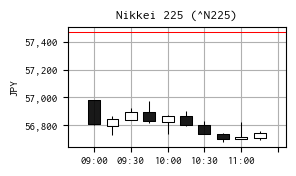

In [7]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in yticker.info:
    ax.set_title(f"{yticker.info['shortName']} ({symbol})")
elif "longName" in yticker.info:
    ax.set_title(f"{yticker.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

In [8]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

In [9]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2026-02-19 09:00:00+09:00,154.682999,154.725998,154.606995,154.725006,0,0.0,0.0
2026-02-19 09:15:00+09:00,154.714996,154.789001,154.697006,154.731995,0,0.0,0.0
2026-02-19 09:30:00+09:00,154.731003,154.837006,154.654007,154.796005,0,0.0,0.0
2026-02-19 09:45:00+09:00,154.787003,154.830002,154.643997,154.725006,0,0.0,0.0
2026-02-19 10:00:00+09:00,154.729004,154.774994,154.647003,154.731003,0,0.0,0.0
...,...,...,...,...,...,...,...
2026-02-20 10:30:00+09:00,155.194000,155.315994,155.188004,155.259995,0,0.0,0.0
2026-02-20 10:45:00+09:00,155.264008,155.268005,155.110001,155.132004,0,0.0,0.0
2026-02-20 11:00:00+09:00,155.132004,155.167007,155.067993,155.076996,0,0.0,0.0


In [10]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2026-02-20 09:00:00+09:00,367.109091,367.109091,365.954169,365.996500
2026-02-20 09:15:00+09:00,366.074209,366.522078,365.652297,366.384613
2026-02-20 09:30:00+09:00,366.372764,366.915041,366.372764,366.745461
2026-02-20 09:45:00+09:00,366.926333,367.406153,366.426788,366.486642
2026-02-20 10:00:00+09:00,366.380268,366.714837,365.817012,366.633663
2026-02-20 10:15:00+09:00,366.425034,366.644032,365.946163,366.012535
2026-02-20 10:30:00+09:00,365.866820,366.012191,365.414152,365.450935
2026-02-20 10:45:00+09:00,365.743434,365.777855,365.371925,365.493118
2026-02-20 11:00:00+09:00,365.615282,366.441837,365.615282,365.706542


In [11]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2026-02-19 15:15:00+09:00


np.float64(155.08399963378906)

前日終値（ドル換算） 370.5593630593929


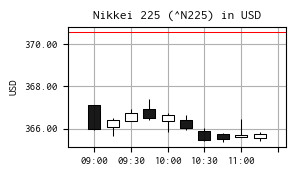

In [12]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.2f}"))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in yticker.info:
    ax.set_title(f"{yticker.info['shortName']} ({symbol}) in USD")
elif "longName" in yticker.info:
    ax.set_title(f"{yticker.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()